In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_predict

from scipy.spatial import distance

## Load dataset

In [2]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

## Split data

In [3]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training_img = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing_img = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [4]:
def get_emotion(whichemotion):
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

(28709, 48, 48)
(28709, 7)
(3589, 48, 48)
(3589, 7)


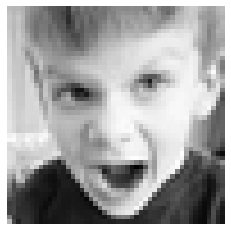

facial emotion: angry


In [5]:
print(x_training_img.shape)
print(y_training.shape)

print(x_testing_img.shape)
print(y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training_img[sampleindex, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.axis('off')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# Part I : Happy or Sad

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

#### Sampling from the data loaded above to include only the happy or sad cases

In [6]:
emotion_list = []
for i in range(0, len(y_training)):
    data = get_emotion(y_training[i, :])
    
    # store DataFrame in list
    emotion_list.append(data)

emotion_df = pd.DataFrame({'emotion' : emotion_list})
emotion_sad_happy_df = emotion_df.loc[emotion_df['emotion'].isin(['sad', 'happy'])]

x_training_sad_happy = x_training[emotion_sad_happy_df.index.tolist()]
y_training_sad_happy = y_training[emotion_sad_happy_df.index.tolist()]

In [7]:
emotion_list_test = []
for i in range(0, len(y_testing)):
    data_test = get_emotion(y_testing[i, :])
    
    # store DataFrame in list
    emotion_list_test.append(data_test)

emotion_df_test = pd.DataFrame({'emotion' : emotion_list_test})
emotion_sad_happy_df_test = emotion_df_test.loc[emotion_df_test['emotion'].isin(['sad', 'happy'])]

x_testing_sad_happy = x_testing[emotion_sad_happy_df_test.index.tolist()]
y_testing_sad_happy = y_testing[emotion_sad_happy_df_test.index.tolist()]

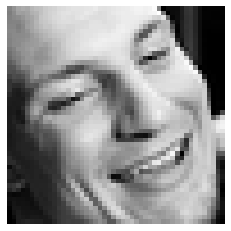

facial emotion: happy


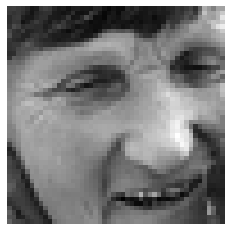

facial emotion: happy


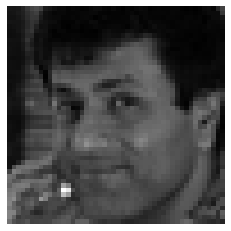

facial emotion: happy


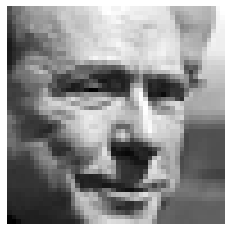

facial emotion: happy


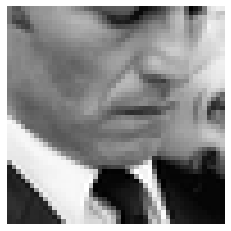

facial emotion: sad


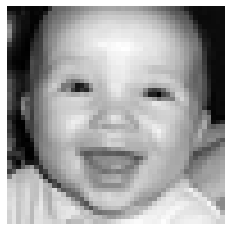

facial emotion: happy


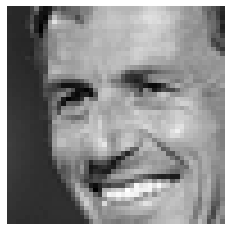

facial emotion: happy


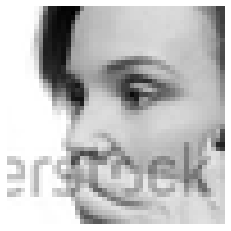

facial emotion: sad


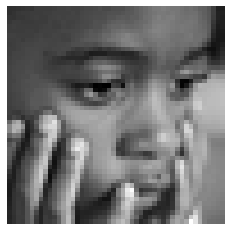

facial emotion: sad


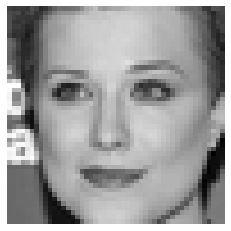

facial emotion: happy


In [8]:
for i in range(10):
    sampleindex = np.random.randint(0,1000)
    sample = x_training_sad_happy[sampleindex, :]
    sample = sample.reshape(48, 48)

    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    plt.show()
    print('facial emotion: %s' % get_emotion(y_training_sad_happy[sampleindex, :]))

#### Applying PCA and LDA to represent the faces, display a sample of a few faces for each case.

### PCA Implementation

In [9]:
# Dimensionality reduction for train data
porc_inf = 0.90

pca = PCA(n_components=porc_inf, svd_solver='full')
x_training_sh_reduced = pca.fit_transform(x_training_sad_happy)

dim_sample_sh = x_training_sad_happy.shape[1]
dim_sample_sh_reduced = x_training_sh_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample_sh} to {dim_sample_sh_reduced} features")
print(f"Aproximately {round(1- (dim_sample_sh_reduced/dim_sample_sh),3)*100}% of the number of its previous features")

Applying PCA (preserving 90.0% of information), the data set reduces from 2304 to 101 features
Aproximately 95.6% of the number of its previous features


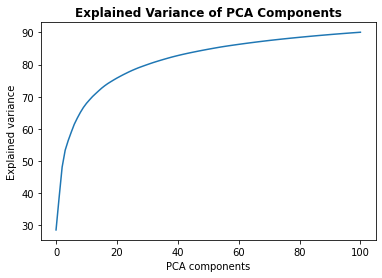

In [11]:
plt.grid()
plt.title("Explained Variance of PCA Components", fontweight = "bold")
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('PCA components')
plt.ylabel('Explained variance')
plt.grid(False)

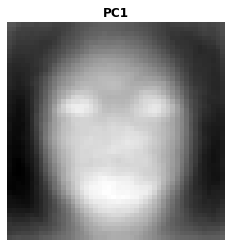

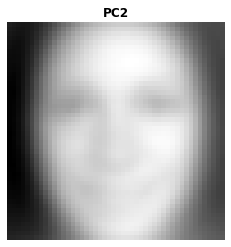

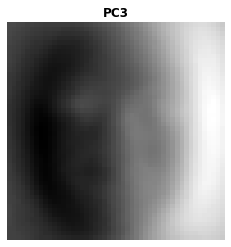

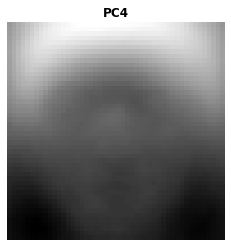

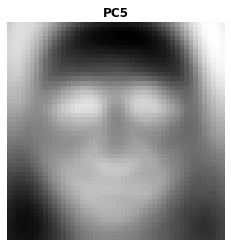

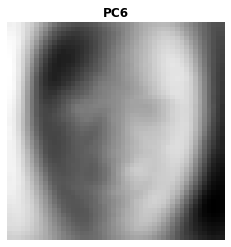

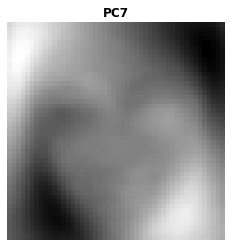

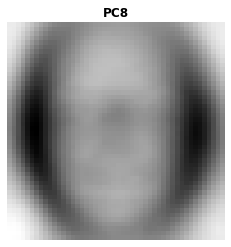

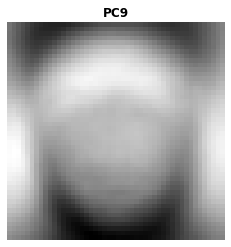

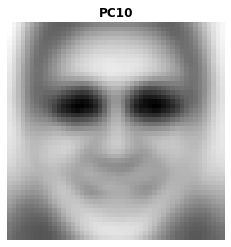

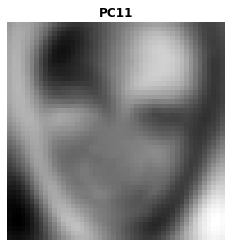

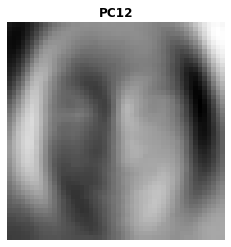

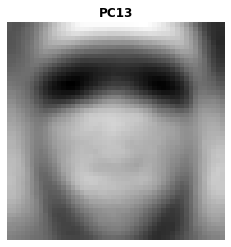

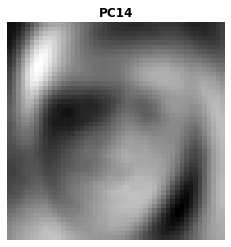

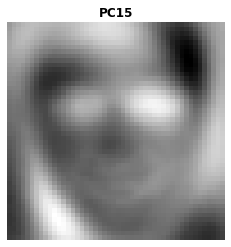

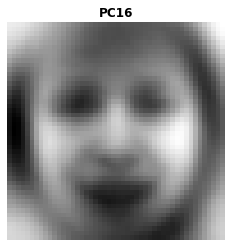

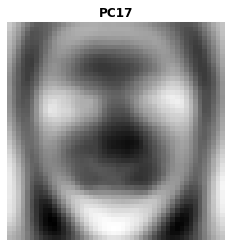

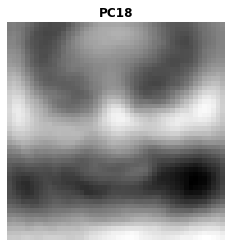

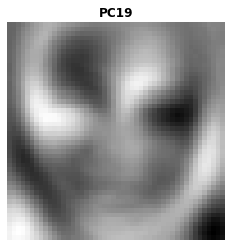

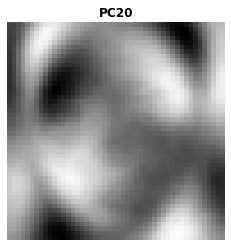

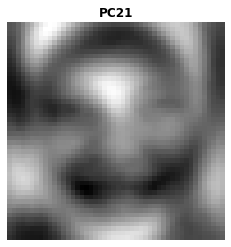

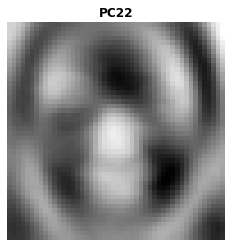

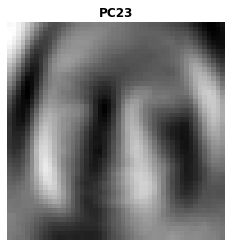

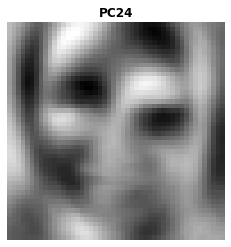

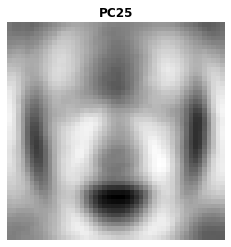

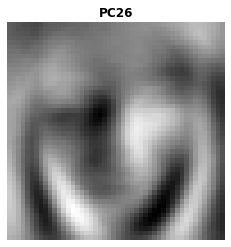

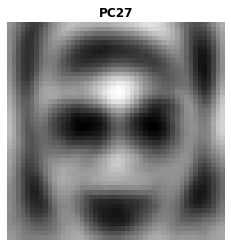

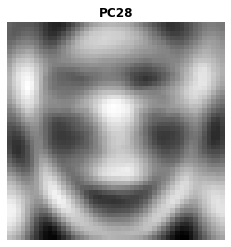

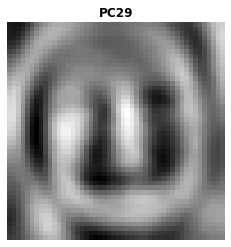

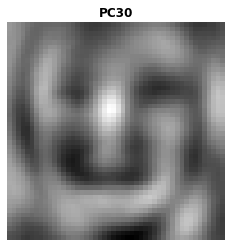

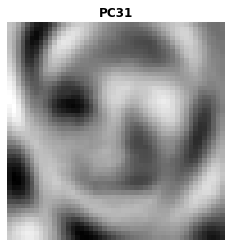

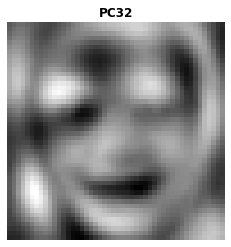

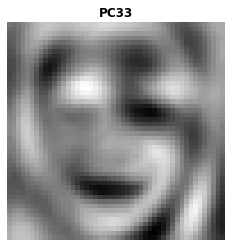

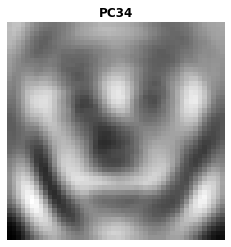

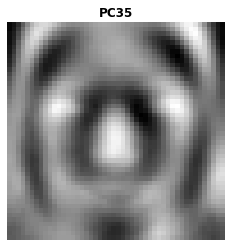

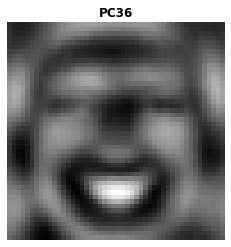

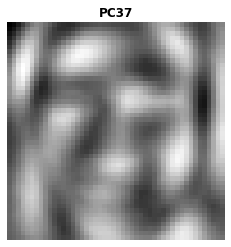

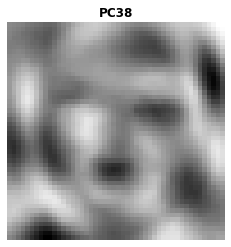

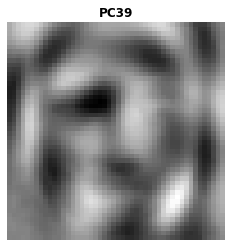

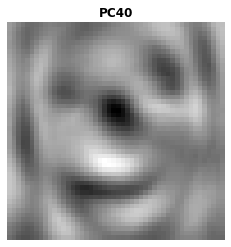

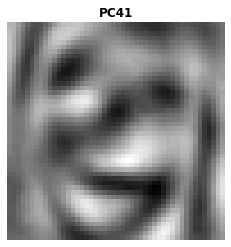

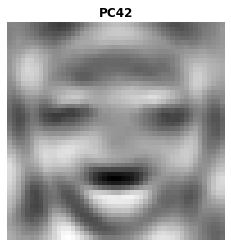

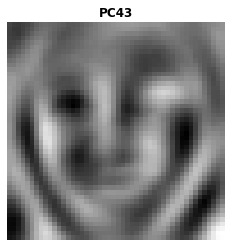

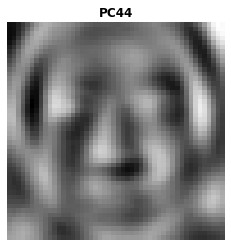

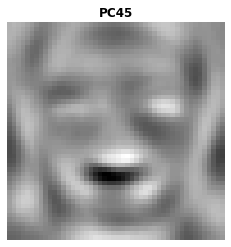

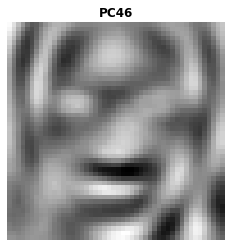

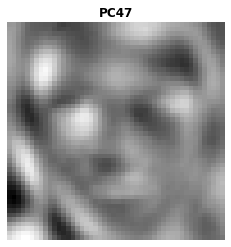

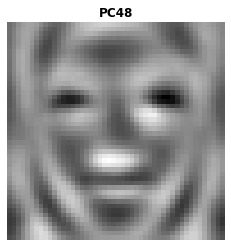

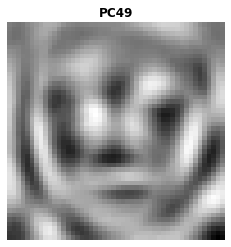

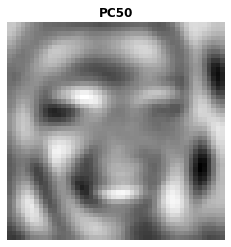

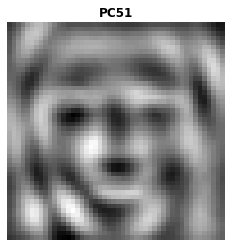

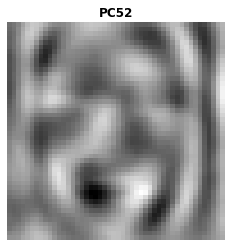

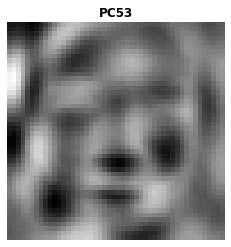

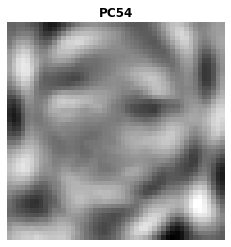

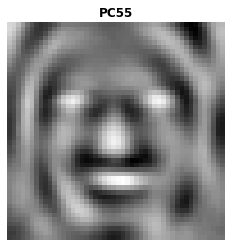

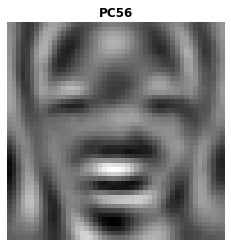

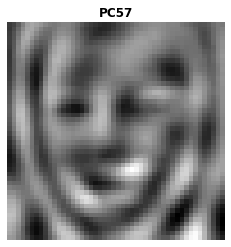

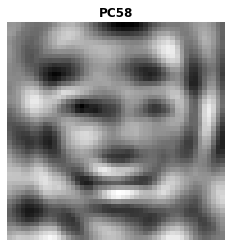

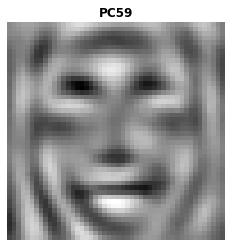

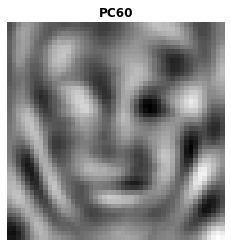

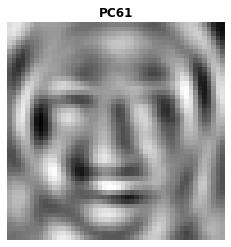

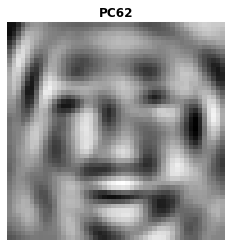

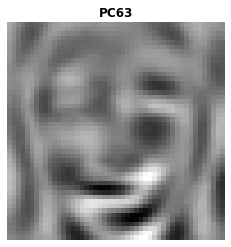

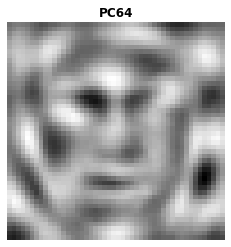

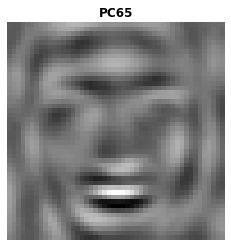

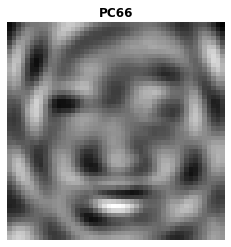

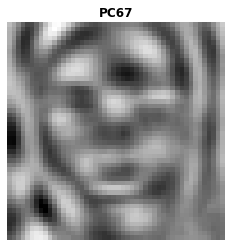

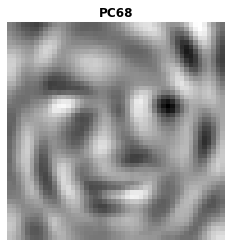

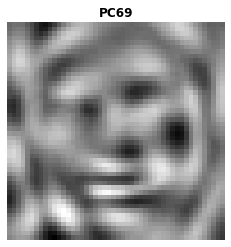

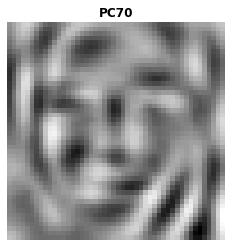

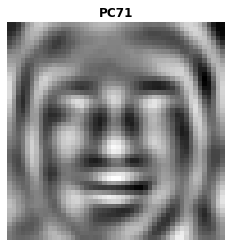

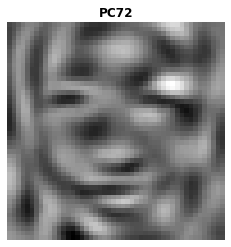

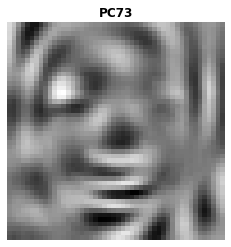

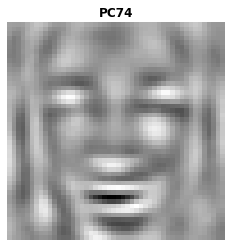

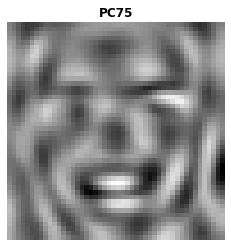

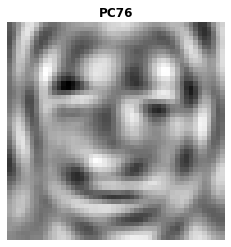

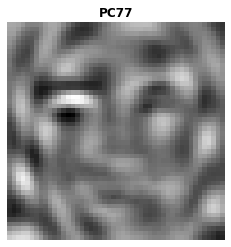

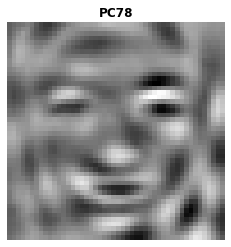

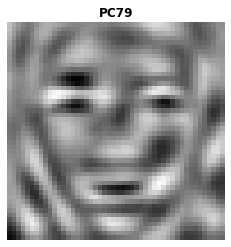

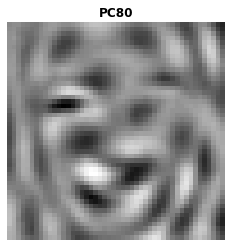

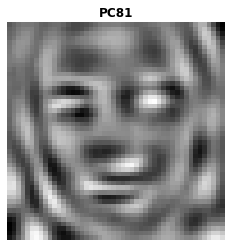

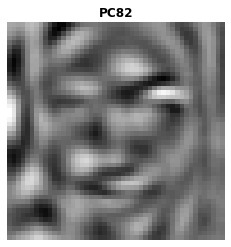

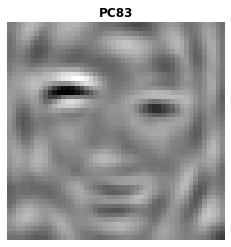

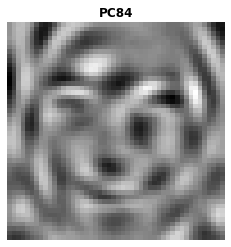

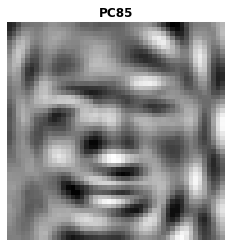

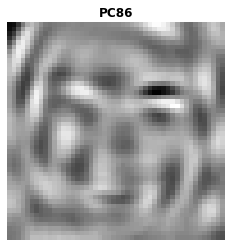

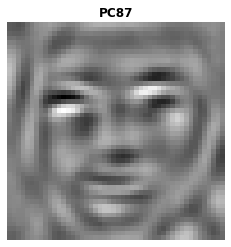

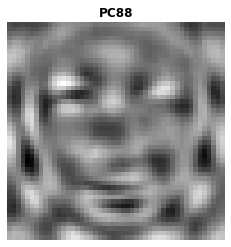

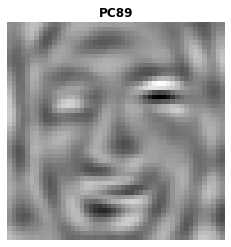

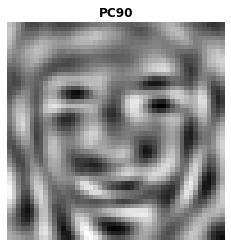

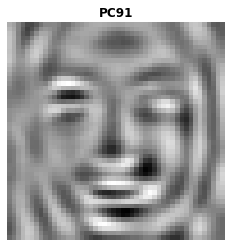

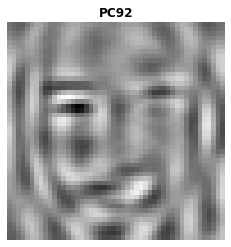

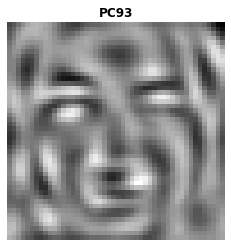

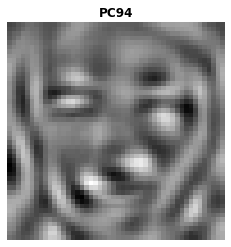

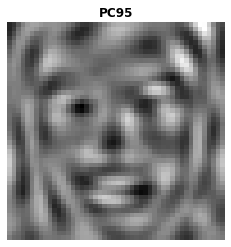

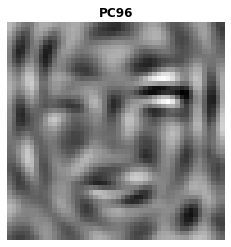

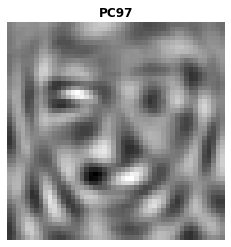

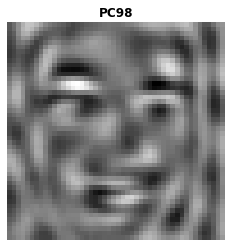

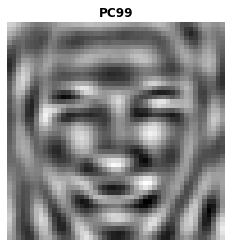

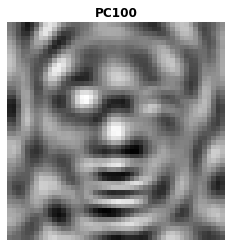

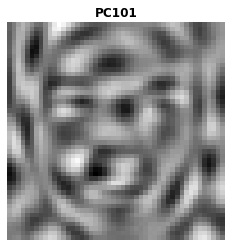

In [12]:
for i in range(101):
    plt.imshow(pca.components_[i].reshape(48, 48), cmap = "gray")
    plt.title("PC" + str(i+1), fontweight = "bold")
    plt.axis('off')
    plt.show()

In [13]:
# Dimensionality reduction for test data
x_testing_sh_reduced = pca.transform(x_testing_sad_happy)

dim_sample_sh_test = x_testing_sad_happy.shape[1]
dim_sample_sh_test_reduced = x_testing_sh_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample_sh_test} to {dim_sample_sh_test_reduced} features")
print(f"Aproximately {round(1- (dim_sample_sh_test_reduced/dim_sample_sh_test),3)*100}% of the number of its previous features")

Applying PCA (preserving 90.0% of information), the data set reduces from 2304 to 101 features
Aproximately 95.6% of the number of its previous features


### LDA Implementation

In [14]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(x_training_sad_happy, emotion_sad_happy_df.values.ravel())
X_test_lda = lda.transform(x_testing_sad_happy)

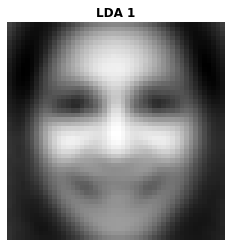

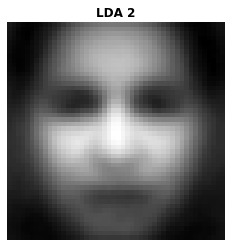

In [15]:
for i in range(2):
    plt.imshow(lda.means_[i].reshape(48, 48), cmap = "gray")
    plt.title("LDA " + str(i+1), fontweight = "bold")
    plt.axis('off')
    plt.show()

### Naive Bayes using PCA

In [16]:
# instantiate the model
gnb_pca = GaussianNB()

# fit the model
gnb_pca.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = gnb_pca.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of Naive Bayes Classifier using PCA: {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Naive Bayes Classifier using PCA: 0.61


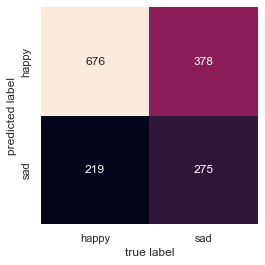

In [17]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [18]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.64      0.76      0.69       895
         sad       0.56      0.42      0.48       653

    accuracy                           0.61      1548
   macro avg       0.60      0.59      0.59      1548
weighted avg       0.61      0.61      0.60      1548



### Naive Bayes using LDA

In [19]:
# instantiate the model
gnb_lda = GaussianNB()

# fit the model
gnb_lda.fit(X_train_lda, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = gnb_lda.predict(X_test_lda)

# Calculating the accuracy of classifier
print(f"Accuracy of Naive Bayes Classifier using LDA: {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Naive Bayes Classifier using LDA: 0.68


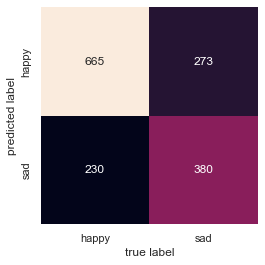

In [20]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [21]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.71      0.74      0.73       895
         sad       0.62      0.58      0.60       653

    accuracy                           0.68      1548
   macro avg       0.67      0.66      0.66      1548
weighted avg       0.67      0.68      0.67      1548



### Logistic Regression using PCA

In [22]:
# instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = logit.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of Logistic Regression using PCA: {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Logistic Regression using PCA: 0.72


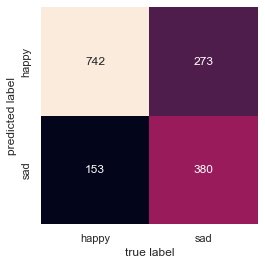

In [23]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [24]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.73      0.83      0.78       895
         sad       0.71      0.58      0.64       653

    accuracy                           0.72      1548
   macro avg       0.72      0.71      0.71      1548
weighted avg       0.72      0.72      0.72      1548



## Logistic Regression using LDA

In [25]:
# instantiate the model
logit_lda = LogisticRegression()

# fit the model
logit_lda.fit(X_train_lda, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = logit_lda.predict(X_test_lda)

# Calculating the accuracy of classifier
print(f"Accuracy of Logistic Regression using LDA: {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Logistic Regression using LDA: 0.67


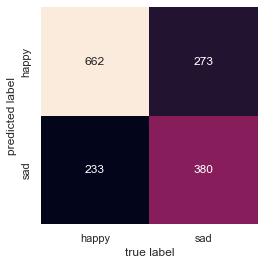

In [26]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [27]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.71      0.74      0.72       895
         sad       0.62      0.58      0.60       653

    accuracy                           0.67      1548
   macro avg       0.66      0.66      0.66      1548
weighted avg       0.67      0.67      0.67      1548



## SVM using PCA

### SVM(kernel = 'rbf', C = 1.0)

In [28]:
start = time.time()

# instantiate the model
rbf_svc = SVC(probability=True) 

# fit the model
rbf_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = rbf_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=1.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=1.0): 0.75
Time taken:  481.0 seconds


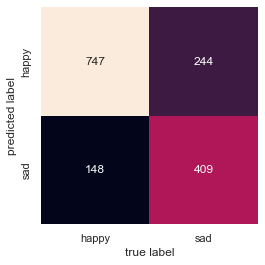

In [29]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [30]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.75      0.83      0.79       895
         sad       0.73      0.63      0.68       653

    accuracy                           0.75      1548
   macro avg       0.74      0.73      0.73      1548
weighted avg       0.75      0.75      0.74      1548



### SVM(kernel = 'rbf', C = 100.0)

In [31]:
start = time.time()

# instantiate the model
rbf_svc = SVC(C=100.0) 

# fit the model
rbf_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = rbf_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=100.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=100.0): 0.73
Time taken:  199.43 seconds


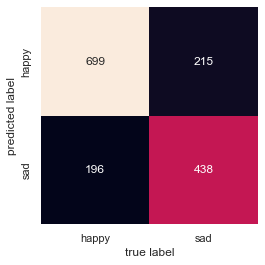

In [32]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [33]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.76      0.78      0.77       895
         sad       0.69      0.67      0.68       653

    accuracy                           0.73      1548
   macro avg       0.73      0.73      0.73      1548
weighted avg       0.73      0.73      0.73      1548



### SVM(kernel = 'poly', C = 1.0)

In [34]:
start = time.time()

# instantiate the model
poly_svc = SVC(kernel='poly', C=1.0) 

# fit the model
poly_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = poly_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=poly, C=1.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=poly, C=1.0): 0.67
Time taken:  45.5 seconds


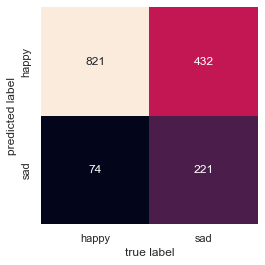

In [35]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [36]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.66      0.92      0.76       895
         sad       0.75      0.34      0.47       653

    accuracy                           0.67      1548
   macro avg       0.70      0.63      0.62      1548
weighted avg       0.69      0.67      0.64      1548



### SVM(kernel = 'poly', C = 100.0)

In [37]:
start = time.time()

# instantiate the model
poly_svc = SVC(kernel='poly', C=100.0) 

# fit the model
poly_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = poly_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=poly, C=100.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=poly, C=100.0): 0.72
Time taken:  277.57 seconds


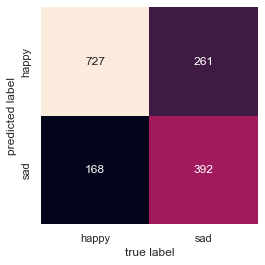

In [38]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [39]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.74      0.81      0.77       895
         sad       0.70      0.60      0.65       653

    accuracy                           0.72      1548
   macro avg       0.72      0.71      0.71      1548
weighted avg       0.72      0.72      0.72      1548



### SVM(kernel = 'poly', C = 1000.0)

In [40]:
start = time.time()

# instantiate the model
poly_svc = SVC(kernel='poly', C=1000.0) 

# fit the model
poly_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = poly_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=poly, C=1000.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=poly, C=1000.0): 0.71
Time taken:  286.38 seconds


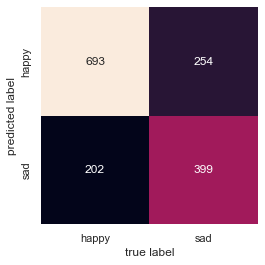

In [41]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [42]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.73      0.77      0.75       895
         sad       0.66      0.61      0.64       653

    accuracy                           0.71      1548
   macro avg       0.70      0.69      0.69      1548
weighted avg       0.70      0.71      0.70      1548



### SVM(kernel = 'sigmoid', C = 1.0)

In [43]:
start = time.time()

# instantiate the model
sigmoid_svc = SVC(kernel='sigmoid', C=1.0) 

# fit the model
sigmoid_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = sigmoid_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=sigmoid, C=1.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=sigmoid, C=1.0): 0.57
Time taken:  25.05 seconds


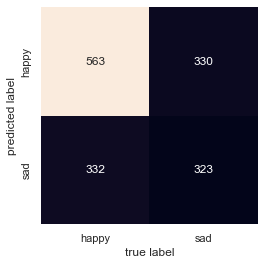

In [44]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [45]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.63      0.63      0.63       895
         sad       0.49      0.49      0.49       653

    accuracy                           0.57      1548
   macro avg       0.56      0.56      0.56      1548
weighted avg       0.57      0.57      0.57      1548



### SVM(kernel = 'sigmoid', C = 100.0)

In [46]:
start = time.time()

# instantiate the model
sigmoid_svc = SVC(kernel='sigmoid', C=100.0) 

# fit the model
sigmoid_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = sigmoid_svc.predict(x_testing_sh_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=sigmoid, C=100.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=sigmoid, C=100.0): 0.57
Time taken:  24.53 seconds


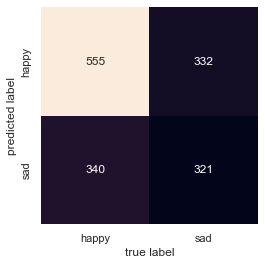

In [47]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [48]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.63      0.62      0.62       895
         sad       0.49      0.49      0.49       653

    accuracy                           0.57      1548
   macro avg       0.56      0.56      0.56      1548
weighted avg       0.57      0.57      0.57      1548



## SVM (kernel = 'rbf', C = 1.0) using LDA

In [49]:
start = time.time()

# instantiate the model
rbf_svc_lda = SVC() 

# fit the model
rbf_svc_lda.fit(X_train_lda, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = rbf_svc_lda.predict(X_test_lda)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=1.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=1.0): 0.67
Time taken:  13.6 seconds


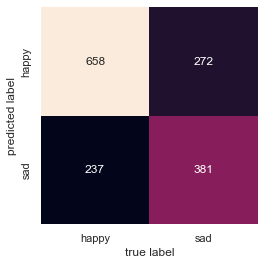

In [50]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [51]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.71      0.74      0.72       895
         sad       0.62      0.58      0.60       653

    accuracy                           0.67      1548
   macro avg       0.66      0.66      0.66      1548
weighted avg       0.67      0.67      0.67      1548



## Final SVM (Kernel = rbf, C=1.0) Model - PCA

In [52]:
start = time.time()

# instantiate the model
rbf_svc = SVC(probability=True) 

# fit the model
rbf_svc.fit(x_training_sh_reduced, emotion_sad_happy_df.values.ravel())

# Predict
y_pred = rbf_svc.predict(x_testing_sh_reduced)


# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=1.0): {round(metrics.accuracy_score(emotion_sad_happy_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=1.0): 0.75
Time taken:  459.92 seconds


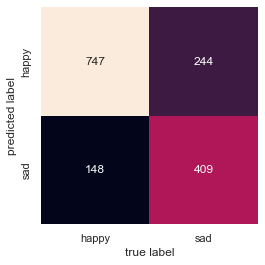

In [53]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_sad_happy_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()),
            yticklabels=np.unique(emotion_sad_happy_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [54]:
print(classification_report(emotion_sad_happy_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_sad_happy_df_test.values.ravel())))

              precision    recall  f1-score   support

       happy       0.75      0.83      0.79       895
         sad       0.73      0.63      0.68       653

    accuracy                           0.75      1548
   macro avg       0.74      0.73      0.73      1548
weighted avg       0.75      0.75      0.74      1548



Implemented Naive Bayes, Logistic Regression and SVM using PCA components as well as LDA. Initially there were 2304 features, after applying PCA the number of features reduced to 101 by retaining 95% of the information. Chose dimensionality reduction features (101 features - PCA) as well as LDA component for further model building. Tried different approaches to maximize the accuracy of the model. Used GaussianNB(), LogisticRegression() and SVC() for Naive Bayes, Logistic Regression and SVM respectively. For SVM, tried kernels like 'rbf', 'linear', 'poly' and 'sigmoid'. Also tweaked the 'C' parameter (C= 1, 10, 100 and 1000), and the 'gamma' parameter as well. When compared to LDA, could observe that PCA gave better results. Out of all the models SVM with kernel = 'rbf' and C = '1.0' performed the best with an accuracy of 75%.

#### Show the 5 happiest faces and the 5 saddest faces.

In [56]:
X_test_pred_prob = rbf_svc.predict_proba(x_testing_sh_reduced)
X_test_pred_prob = X_test_pred_prob.max(axis=1)
pred_prob_df_test = pd.DataFrame({'y_pred': y_pred, 'pred_prob': X_test_pred_prob})
pred_prob_df_test = pred_prob_df_test.sort_values(['y_pred', 'pred_prob'], ascending=False).groupby('y_pred').head(5)
pred_prob_df_test = pred_prob_df_test.sort_values(by="y_pred", ascending=False)
pred_prob_df_test

,y_pred,pred_prob
1216,sad,0.984149
1512,sad,0.982294
307,sad,0.981738
1132,sad,0.981184
1203,sad,0.978634
491,happy,0.994212
816,happy,0.991940
948,happy,0.991756
472,happy,0.989414
1218,happy,0.985716


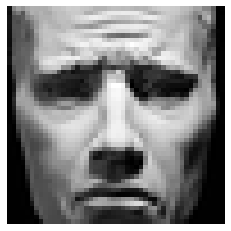

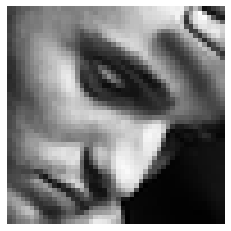

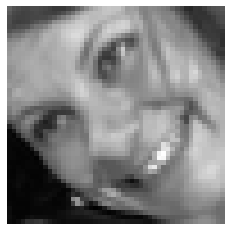

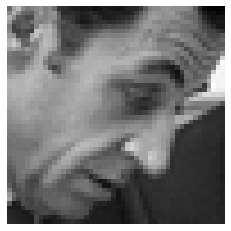

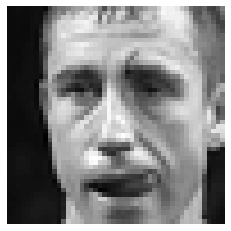

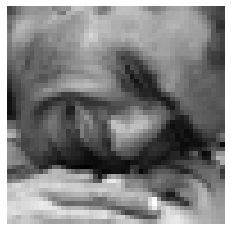

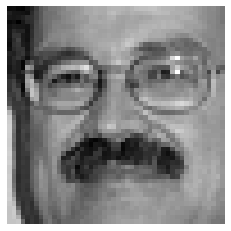

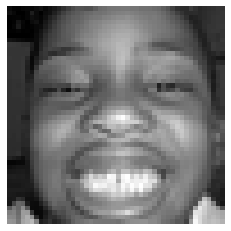

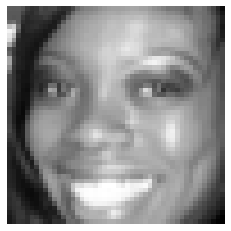

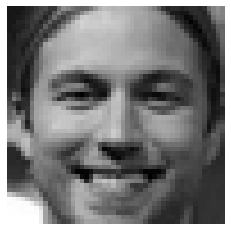

In [57]:
index = pred_prob_df_test.index

for i in range(len(index)):
    sampleindex = index[i]
    sample = x_testing_sad_happy[sampleindex, :]
    sample = sample.reshape(48, 48)

    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    plt.show()

# Part II : Multi-class

Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces

## PCA Implementation

In [58]:
# Dimensionality reduction for train data
porc_inf = 0.90
pca = PCA(n_components=porc_inf, svd_solver='full')
x_training_reduced = pca.fit_transform(x_training)

dim_sample = x_training.shape[1]
dim_sample_reduced = x_training_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample} to {dim_sample_reduced} features")
print(f"Aproximately {round(1- (dim_sample_reduced/dim_sample),3)*100}% of the number of its previous features")

Applying PCA (preserving 90.0% of information), the data set reduces from 2304 to 103 features
Aproximately 95.5% of the number of its previous features


In [59]:
# Dimensionality reduction for test data
x_testing_reduced = pca.transform(x_testing)

dim_sample_test = x_testing.shape[1]
dim_sample_test_reduced = x_testing_reduced.shape[1]
print(f"Applying PCA (preserving {porc_inf*100}% of information), the data set reduces from {dim_sample_test} to {dim_sample_test_reduced} features")
print(f"Aproximately {round(1- (dim_sample_test_reduced/dim_sample_test),3)*100}% of the number of its previous features")

Applying PCA (preserving 90.0% of information), the data set reduces from 2304 to 103 features
Aproximately 95.5% of the number of its previous features


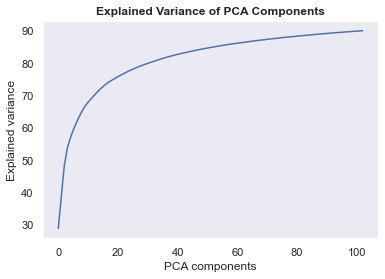

In [60]:
plt.grid()
plt.title("Explained Variance of PCA Components", fontweight = "bold")
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('PCA components')
plt.ylabel('Explained variance')
plt.grid(False)

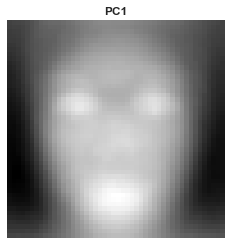

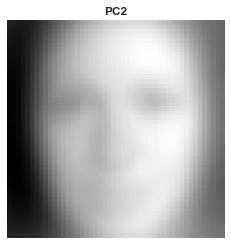

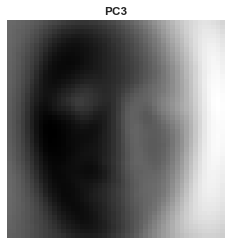

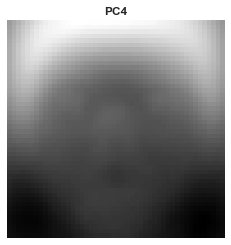

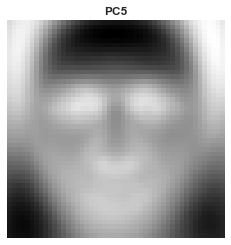

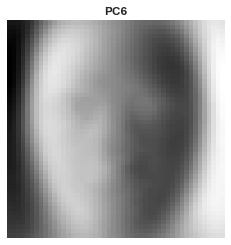

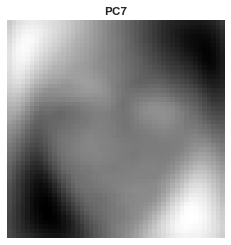

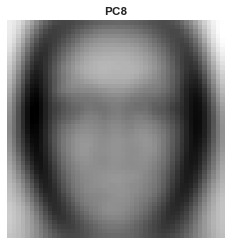

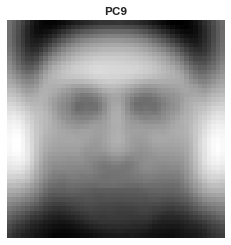

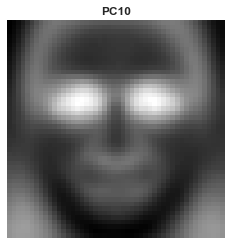

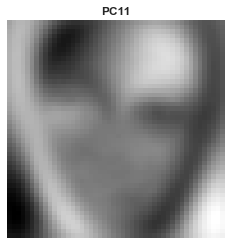

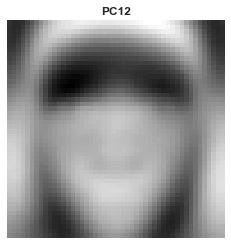

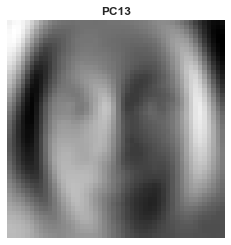

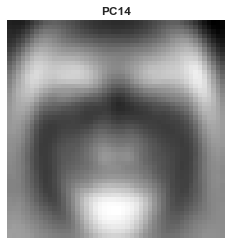

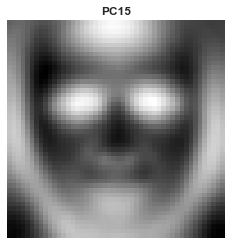

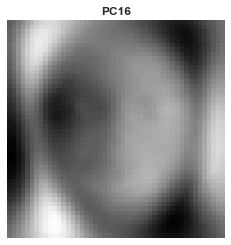

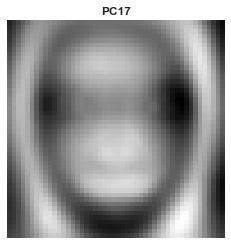

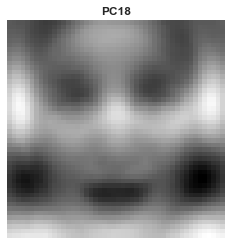

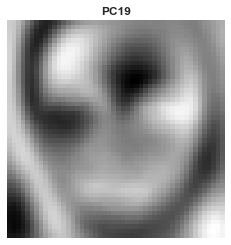

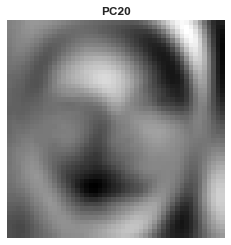

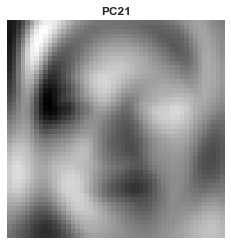

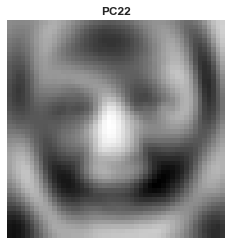

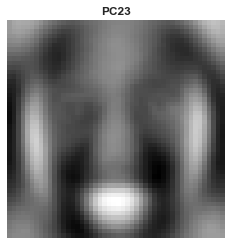

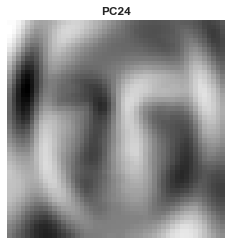

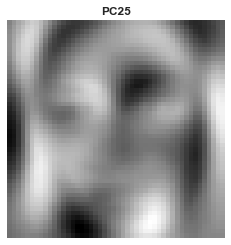

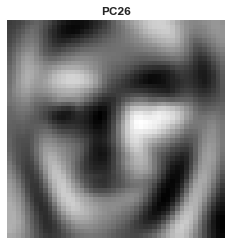

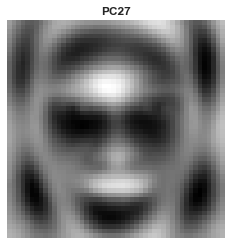

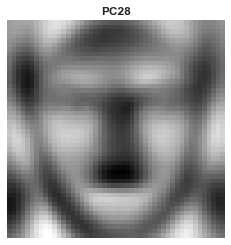

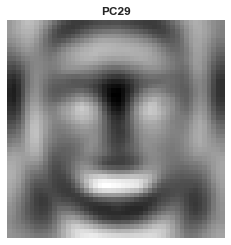

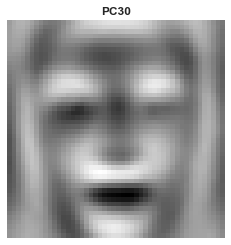

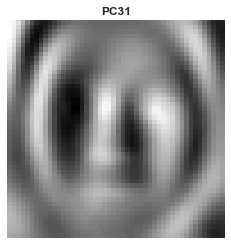

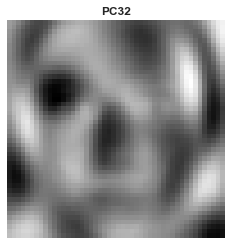

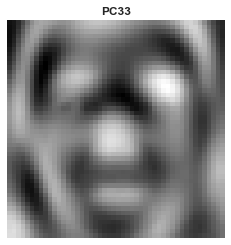

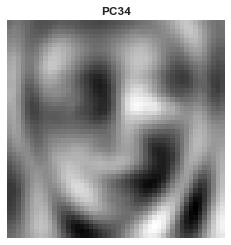

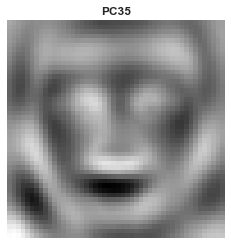

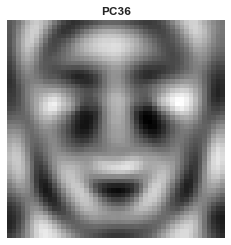

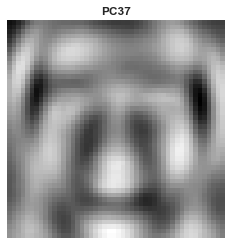

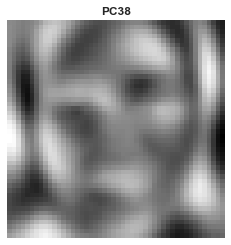

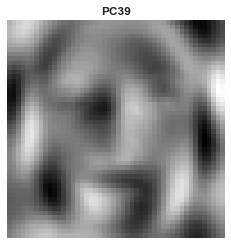

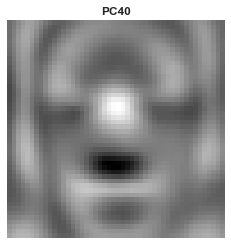

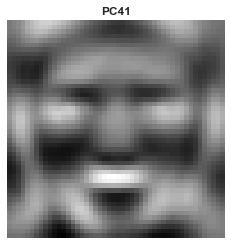

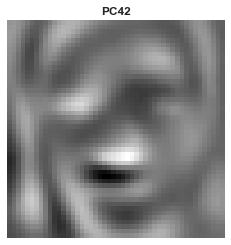

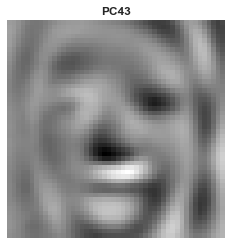

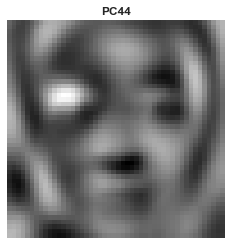

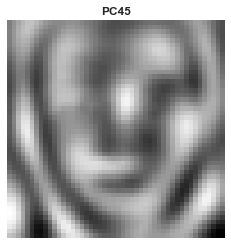

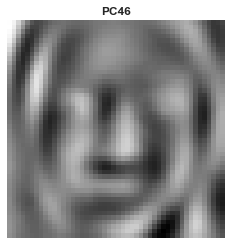

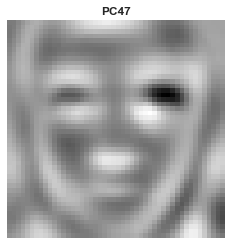

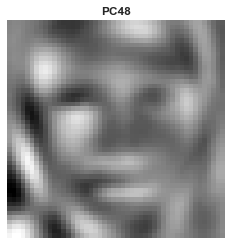

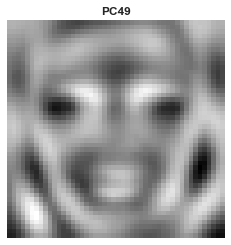

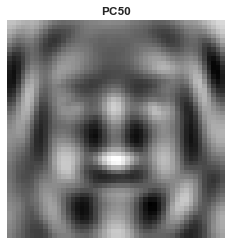

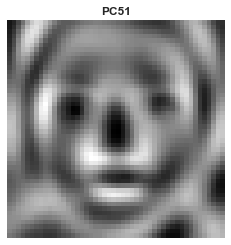

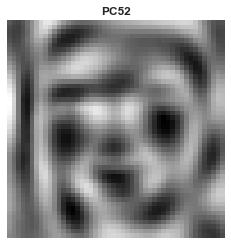

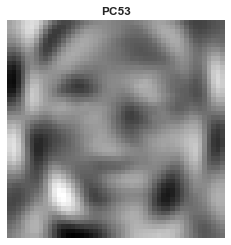

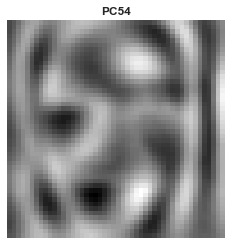

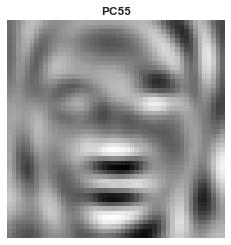

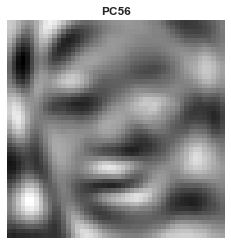

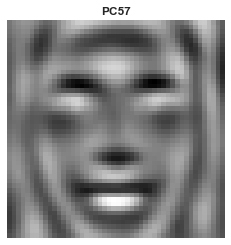

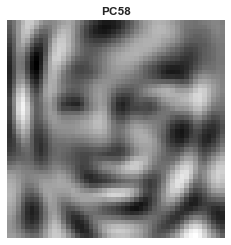

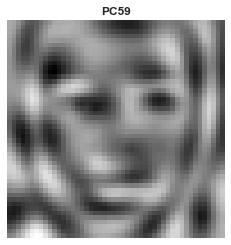

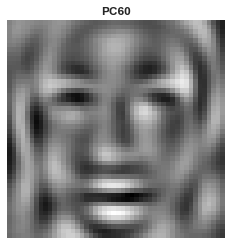

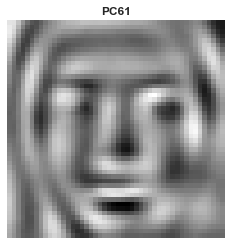

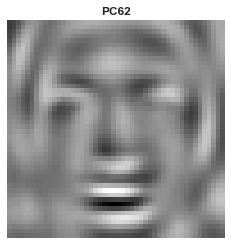

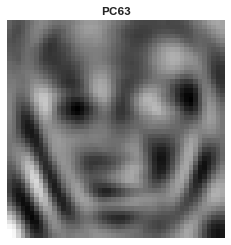

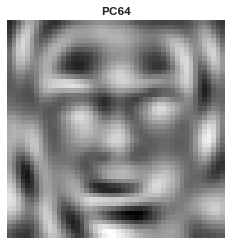

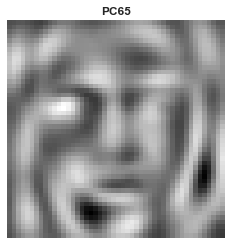

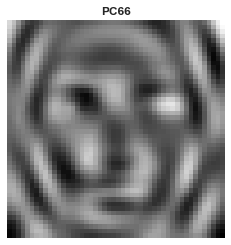

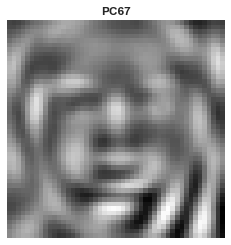

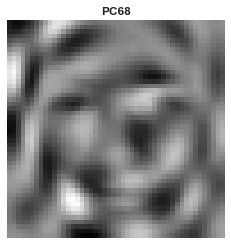

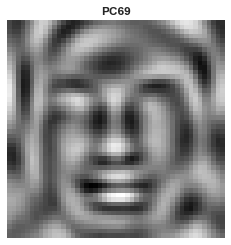

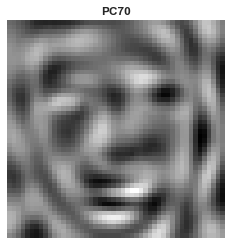

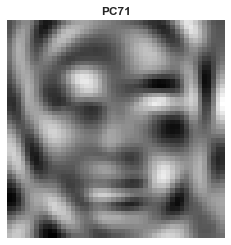

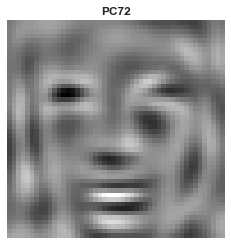

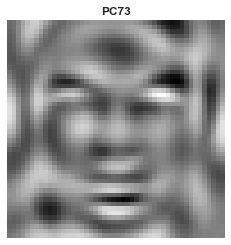

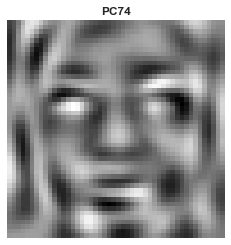

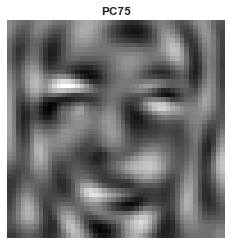

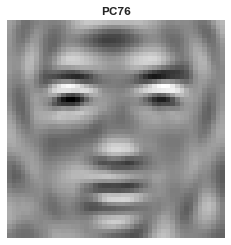

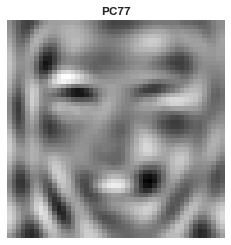

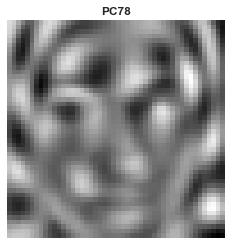

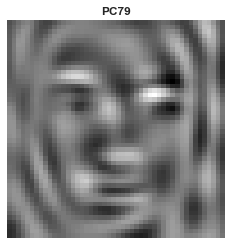

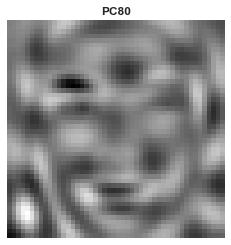

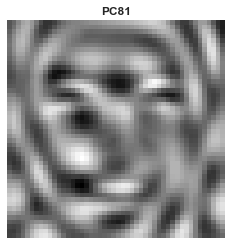

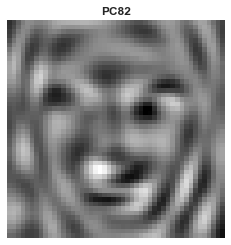

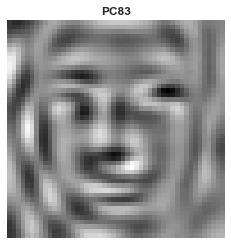

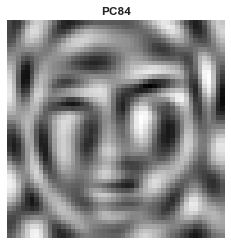

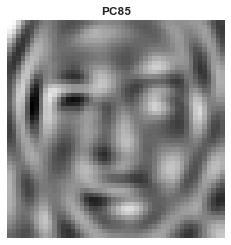

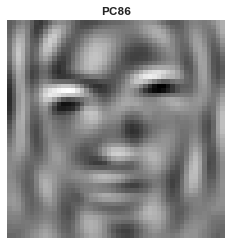

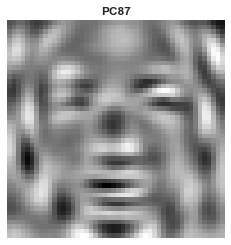

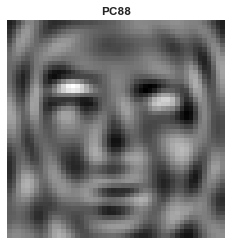

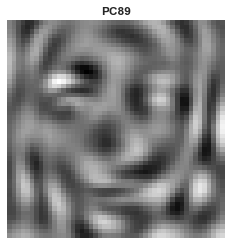

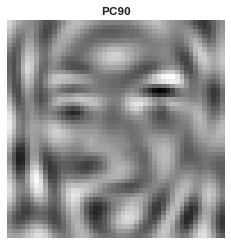

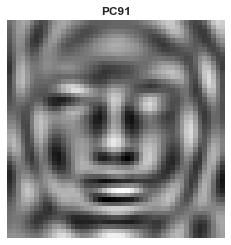

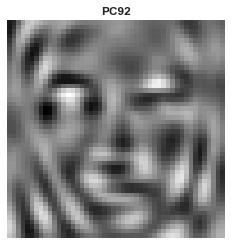

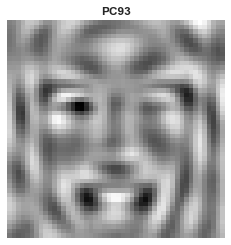

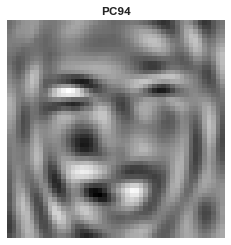

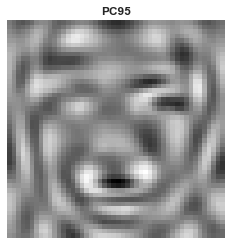

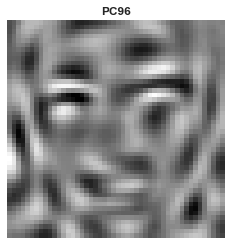

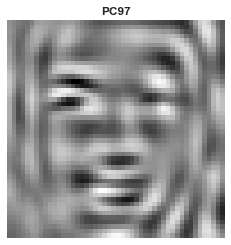

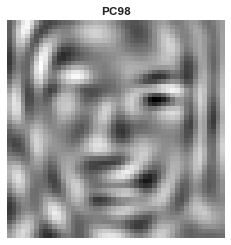

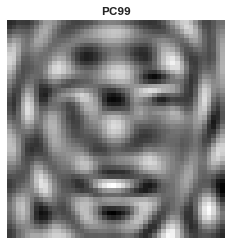

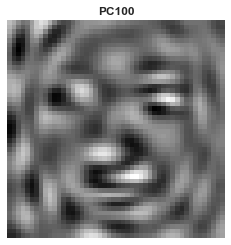

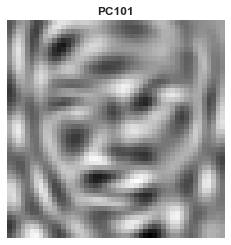

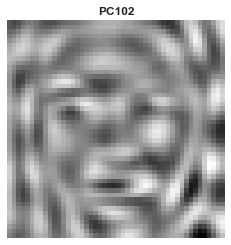

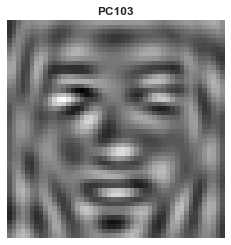

In [61]:
for i in range(103):
    plt.imshow(pca.components_[i].reshape(48, 48), cmap = "gray")
    plt.title("PC" + str(i+1), fontweight = "bold")
    plt.axis('off')
    plt.show()

## LDA Implementation

In [62]:
lda = LDA()
X_train_lda = lda.fit_transform(x_training, emotion_df.values.ravel())
X_test_lda = lda.transform(x_testing)

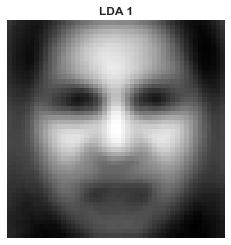

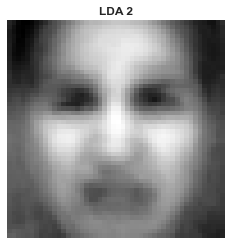

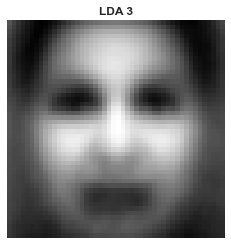

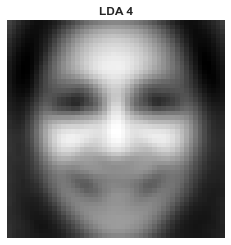

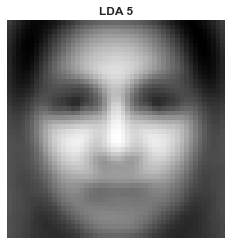

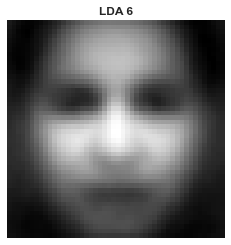

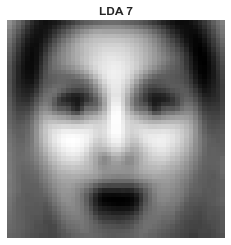

In [63]:
for i in range(7):
    plt.imshow(lda.means_[i].reshape(48, 48), cmap = "gray")
    plt.title("LDA " + str(i+1), fontweight = "bold")
    plt.axis('off')
    plt.show()

## Naive Bayes using PCA

In [64]:
# instantiate the model
gnb_pca = GaussianNB()

# fit the model
gnb_pca.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = gnb_pca.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of Naive Bayes Classifier: {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Naive Bayes Classifier: 0.34


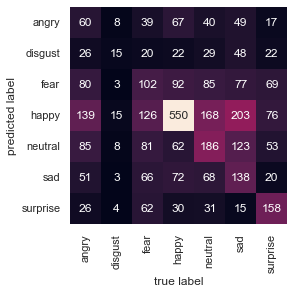

In [65]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

For multi-classification we have used GaussianNB as the features are integers and it is normally distributed. The overall acuuracy of Naive Baye's is 0.34% which is below average performance. From the confusion matrix, it is evident that Bayesian model is more inclined towards the 'happy' and 'surprise' class.

In [66]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.21      0.13      0.16       467
     disgust       0.08      0.27      0.13        56
        fear       0.20      0.21      0.20       496
       happy       0.43      0.61      0.51       895
     neutral       0.31      0.31      0.31       607
         sad       0.33      0.21      0.26       653
    surprise       0.48      0.38      0.43       415

    accuracy                           0.34      3589
   macro avg       0.29      0.30      0.28      3589
weighted avg       0.33      0.34      0.33      3589



## Logistic Regression using PCA

In [67]:
# instantiate the model
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# fit the model
logit.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = logit.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of Logistic Regression: {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

Accuracy of Logistic Regression: 0.38


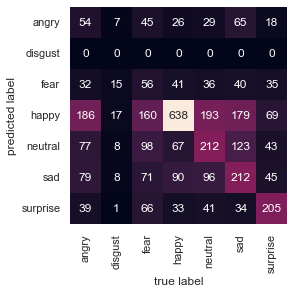

In [68]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In LogisticRegression, we have used the parameters multi_class='multinomial', as it is multi classification and solver='lbfgs', max_iter=1000 due to the input size. While dealing with multi classification problem, the performance of LogisticRegrssion is also par below average with an accuracy of 0.38.

In [69]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.22      0.12      0.15       467
     disgust       0.00      0.00      0.00        56
        fear       0.22      0.11      0.15       496
       happy       0.44      0.71      0.55       895
     neutral       0.34      0.35      0.34       607
         sad       0.35      0.32      0.34       653
    surprise       0.49      0.49      0.49       415

    accuracy                           0.38      3589
   macro avg       0.29      0.30      0.29      3589
weighted avg       0.35      0.38      0.35      3589



## SVM using PCA

### SVM (kernel=rbf, C=1.0)

In [70]:
start = time.time()

# instantiate the model
rbf_svc = SVC(decision_function_shape='ovo') 

# fit the model
rbf_svc.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = rbf_svc.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=1.0): {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=1.0): 0.44
Time taken:  491.63 seconds


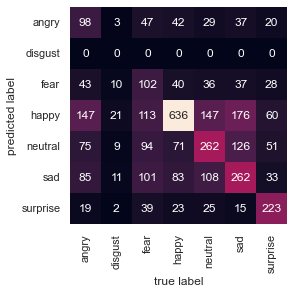

In [71]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [72]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.36      0.21      0.26       467
     disgust       0.00      0.00      0.00        56
        fear       0.34      0.21      0.26       496
       happy       0.49      0.71      0.58       895
     neutral       0.38      0.43      0.40       607
         sad       0.38      0.40      0.39       653
    surprise       0.64      0.54      0.59       415

    accuracy                           0.44      3589
   macro avg       0.37      0.36      0.35      3589
weighted avg       0.42      0.44      0.42      3589



### SVM (kernel=poly, C=1.0)

In [73]:
start = time.time()

# instantiate the model
poly_svc = SVC(kernel='poly', C=1.0) 

# fit the model
poly_svc.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = poly_svc.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=poly, C=1.0): {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=poly, C=1.0): 0.38
Time taken:  510.58 seconds


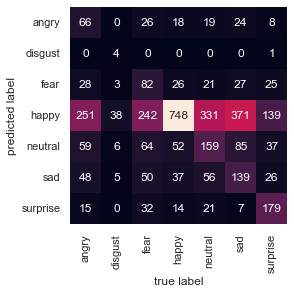

In [74]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [75]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.41      0.14      0.21       467
     disgust       0.80      0.07      0.13        56
        fear       0.39      0.17      0.23       496
       happy       0.35      0.84      0.50       895
     neutral       0.34      0.26      0.30       607
         sad       0.39      0.21      0.27       653
    surprise       0.67      0.43      0.52       415

    accuracy                           0.38      3589
   macro avg       0.48      0.30      0.31      3589
weighted avg       0.41      0.38      0.35      3589



### SVM (kernel=poly, C=100.0)

In [76]:
start = time.time()

# instantiate the model
poly_svc = SVC(kernel='poly', C=100.0) 

# fit the model
poly_svc.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = poly_svc.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=poly, C=100.0): {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=poly, C=100.0): 0.42
Time taken:  1201.93 seconds


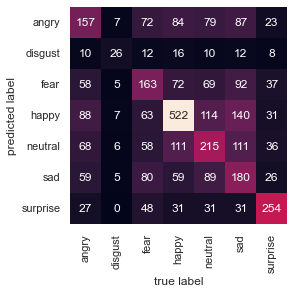

In [77]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [78]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.31      0.34      0.32       467
     disgust       0.28      0.46      0.35        56
        fear       0.33      0.33      0.33       496
       happy       0.54      0.58      0.56       895
     neutral       0.36      0.35      0.35       607
         sad       0.36      0.28      0.31       653
    surprise       0.60      0.61      0.61       415

    accuracy                           0.42      3589
   macro avg       0.40      0.42      0.40      3589
weighted avg       0.42      0.42      0.42      3589



### SVM (kernel=sigmoid, C=1.0)

In [79]:
start = time.time()

# instantiate the model
sigmoid_svc = SVC(kernel='sigmoid', C=1.0) 

# fit the model
sigmoid_svc.fit(x_training_reduced, emotion_df.values.ravel())

# Predict
y_pred = sigmoid_svc.predict(x_testing_reduced)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=sigmoid, C=1.0): {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=sigmoid, C=1.0): 0.2
Time taken:  136.83 seconds


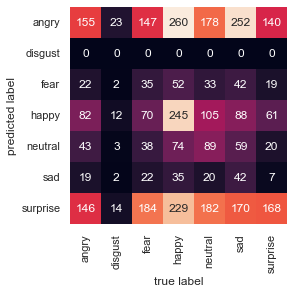

In [80]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

Using SVM, done the same parameter tuning as 'Binary Classification', and  could observe that the accuracy of multi classifier was less when compared to binary classification, however SVM gave better accuracy than the other models for multi-classification.

In [81]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.13      0.33      0.19       467
     disgust       0.00      0.00      0.00        56
        fear       0.17      0.07      0.10       496
       happy       0.37      0.27      0.31       895
     neutral       0.27      0.15      0.19       607
         sad       0.29      0.06      0.10       653
    surprise       0.15      0.40      0.22       415

    accuracy                           0.20      3589
   macro avg       0.20      0.18      0.16      3589
weighted avg       0.25      0.20      0.19      3589



## SVM using LDA

In [92]:
start = time.time()

# instantiate the model
rbf_svc = SVC(decision_function_shape='ovo', probability=True) 

# fit the model
rbf_svc.fit(X_train_lda, emotion_df.values.ravel())

# Predict
y_pred = rbf_svc.predict(X_test_lda)

# Calculating the accuracy of classifier
print(f"Accuracy of SVM (kernel=rbf, C=1.0): {round(metrics.accuracy_score(emotion_df_test.values.ravel(), y_pred), 2)}")

end = time.time()
print("Time taken: ", round((end - start),2), "seconds")

Accuracy of SVM (kernel=rbf, C=1.0): 0.35
Time taken:  200.71 seconds


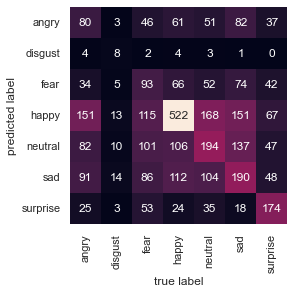

In [93]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(emotion_df_test.values.ravel(), y_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(emotion_df_test.values.ravel()),
            yticklabels=np.unique(emotion_df_test.values.ravel()))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [94]:
print(classification_report(emotion_df_test.values.ravel(), y_pred,
                            target_names=np.unique(emotion_df_test.values.ravel())))

              precision    recall  f1-score   support

       angry       0.22      0.17      0.19       467
     disgust       0.36      0.14      0.21        56
        fear       0.25      0.19      0.22       496
       happy       0.44      0.58      0.50       895
     neutral       0.29      0.32      0.30       607
         sad       0.29      0.29      0.29       653
    surprise       0.52      0.42      0.47       415

    accuracy                           0.35      3589
   macro avg       0.34      0.30      0.31      3589
weighted avg       0.34      0.35      0.34      3589



## Hyperparameter tuning using grid search and cross validation

In [ ]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

## Training SVM model

In [ ]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(x_training_reduced, emotion_df.values.ravel())

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(x_testing_reduced)

## Image Similarity Matching using Euclidean Distance

In [85]:
dist = []
img_pair = []

for i in range(len(lda.means_)):
    try:
        for j in range(len(lda.means_)):
            
            dist.append(distance.euclidean(lda.means_[i], lda.means_[j+1]))
            img_pair.append((i, j+1))
    
    except IndexError:
        pass

In [86]:
similar_img_euclidean_df = pd.DataFrame({"Img_pair" : img_pair, 'Distance': dist})
similar_img_euclidean_df = similar_img_euclidean_df[similar_img_euclidean_df.Distance != 0]
similar_img_euclidean_df = similar_img_euclidean_df.sort_values(['Distance'], ascending=True)
similar_img_euclidean_df

,Img_pair,Distance
4,"(0, 5)",289.375312
7,"(1, 2)",309.688869
12,"(2, 1)",309.688869
33,"(5, 4)",311.834884
28,"(4, 5)",311.834884
2,"(0, 3)",335.314083
3,"(0, 4)",360.161315
26,"(4, 3)",366.495818
21,"(3, 4)",366.495818
19,"(3, 2)",439.311846


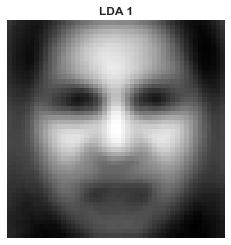

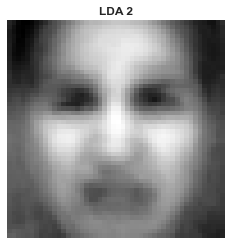

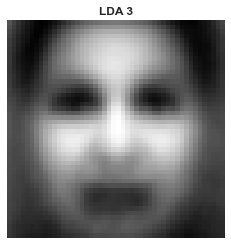

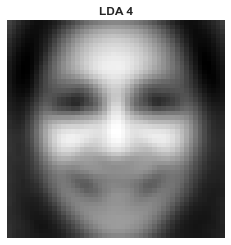

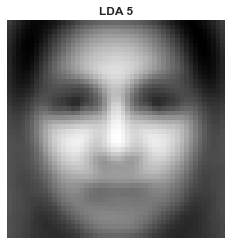

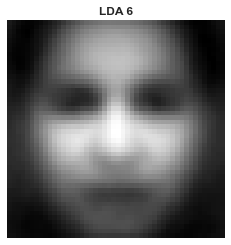

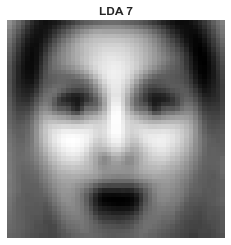

In [87]:
for i in range(7):
    plt.imshow(lda.means_[i].reshape(48, 48), cmap = "gray")
    plt.title("LDA " + str(i+1), fontweight = "bold")
    plt.axis('off')
    plt.show()

Applied euclidean distance in LDA components, to measure the minimum distance between two LDA component array which means that the images are similar, otherwise if the distance increases then the images are dissimmilar. Calculated this with scipy.spatial package and have created a matrix. Identifed the similar images as 'angry' and 'sad'. The dissimilar images are 'sad' and 'surprise'. The respective measurements are '289.37' and '1262.90'. It is evident from the above LDA visualization.

## Identify Misclassified Label using Cross Validation K-fold

In [88]:
from sklearn.model_selection import cross_val_predict

rbf_svc = SVC(decision_function_shape='ovo', probability=True) 
num_crossval_folds = 5
pred_probs = cross_val_predict(rbf_svc, x_training_reduced, emotion_df.values.ravel(),
                               cv=num_crossval_folds,
                               method='predict_proba')

In [97]:
X_test_pred_prob = rbf_svc.predict_proba(X_test_lda)
X_test_pred_prob = X_test_pred_prob.max(axis=1)
pred_prob_df_test = pd.DataFrame({'y_pred': y_pred, 'pred_prob': X_test_pred_prob})
pred_prob_df_test = pred_prob_df_test.sort_values(['y_pred', 'pred_prob'], ascending=False).groupby('y_pred').tail(5)
pred_prob_df_test = pred_prob_df_test.sort_values(by="y_pred", ascending=False)
pred_prob_df_test

,y_pred,pred_prob
460,surprise,0.274718
104,surprise,0.267845
9,surprise,0.267069
3111,surprise,0.252868
1234,surprise,0.272094
901,sad,0.232572
21,sad,0.178532
1780,sad,0.193243
2518,sad,0.233835
1817,sad,0.237685


facial emotion: surprise


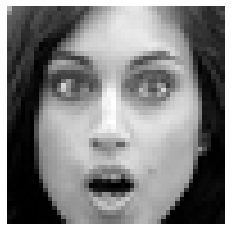

facial emotion: fear


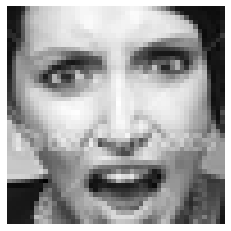

facial emotion: angry


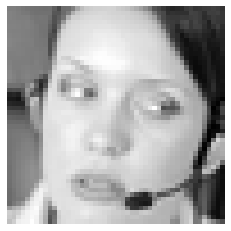

facial emotion: neutral


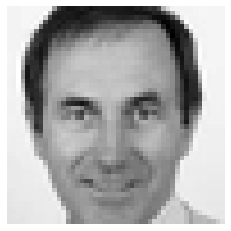

facial emotion: neutral


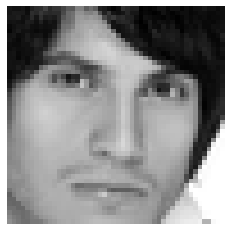

facial emotion: fear


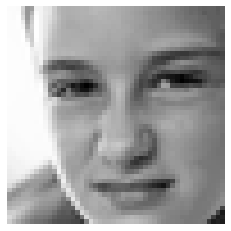

facial emotion: surprise


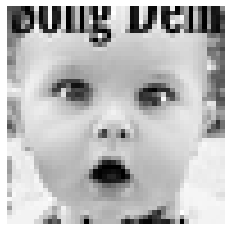

facial emotion: surprise


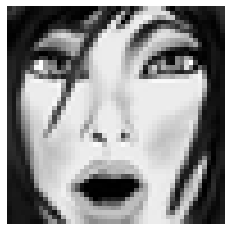

facial emotion: sad


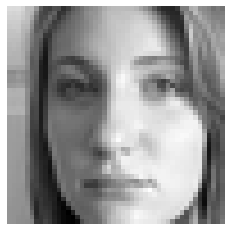

facial emotion: angry


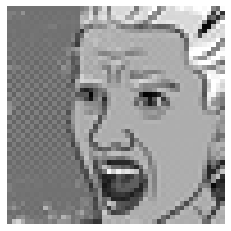

facial emotion: neutral


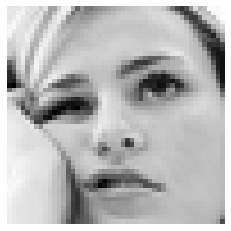

facial emotion: neutral


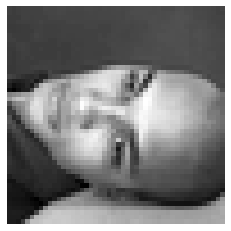

facial emotion: disgust


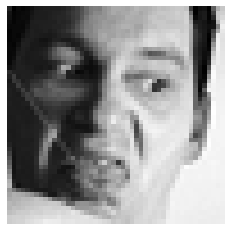

facial emotion: fear


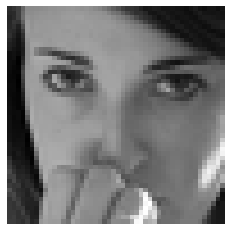

facial emotion: happy


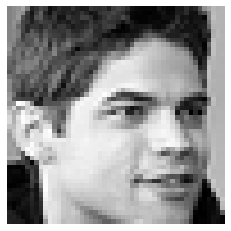

facial emotion: sad


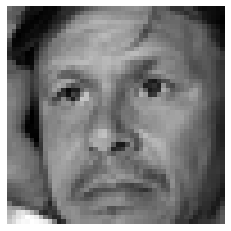

facial emotion: surprise


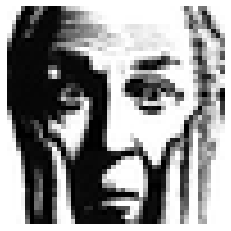

facial emotion: sad


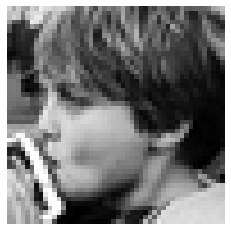

facial emotion: surprise


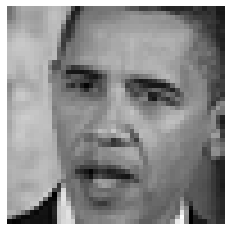

facial emotion: neutral


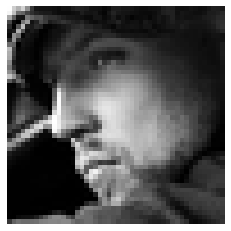

facial emotion: fear


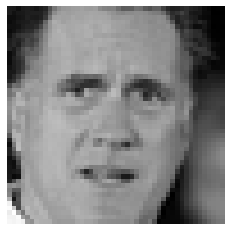

facial emotion: surprise


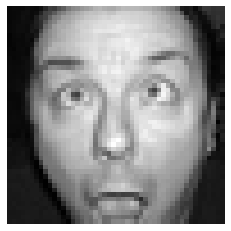

facial emotion: fear


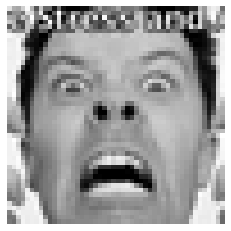

facial emotion: surprise


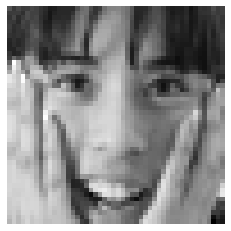

facial emotion: sad


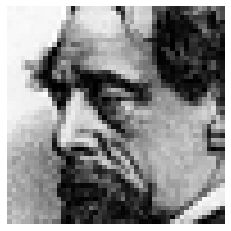

facial emotion: happy


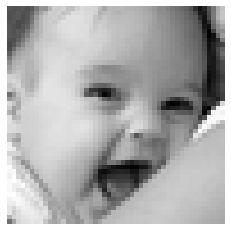

facial emotion: angry


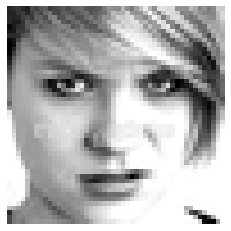

facial emotion: disgust


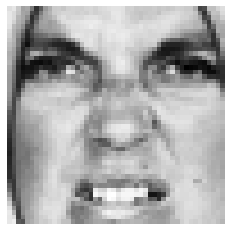

facial emotion: angry


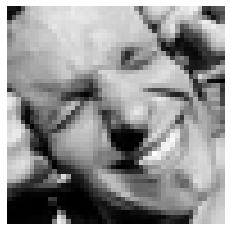

facial emotion: sad


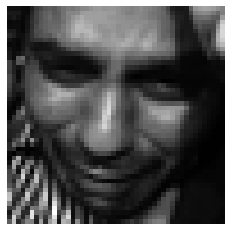

facial emotion: sad


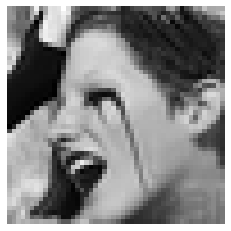

facial emotion: surprise


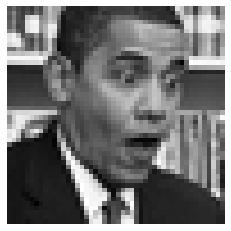

facial emotion: neutral


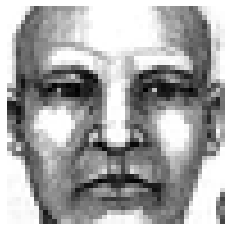

facial emotion: sad


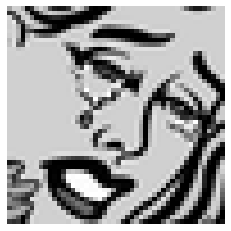

facial emotion: sad


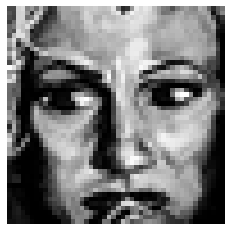

In [99]:
index = pred_prob_df_test.index

for i in range(len(index)):
    sampleindex = index[i]
    sample = x_testing[sampleindex, :]
    sample = sample.reshape(48, 48)

    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    print('facial emotion: %s' % get_emotion(y_testing[sampleindex, :]))
    plt.show()

K-fold cross-validation is a technique where in each model is used as a test set at least one and the remaining will be used as training set. Here 'K' represents the number of iterations that the dataset passes through. Since it iterates multiple times, there is a high chance that the cross validation can identify mislabeled classes through K-fold iterations. In cross validation K-fold technique there is 'predict_proba' parameter which gives the probability of predictions for each observation. If the probability is very less after the cross-validation process, we can identify it as a mislabeled image.